## **Análisis de Sistemas Térmicos usando Python**

Clase 5:    Uso de biblioteca fluids para evaluar pérdida de carga en tuberías

            Uso de unidades en Python

Primero instalamos en Colab las librerías necesarias para el desarrollo del ejemplo

In [ ]:
#pip install Coolprop

In [ ]:
#pip install fluids

En este ejemplo buscamos analizar el sistema de tuberías que se muestra en la figura. 

El sistema transporta agua, a 20°C, en una tubería de 38 mts de longitud en la horizontal y una diferencia de altura de 8 mts.

Buscamos evaluar el efecto del diámetro de la tubería en la potencia requerida por el sistema de bombas, con tal de asegurar un caudal de 20 litros por minuto.

<img src="Fig Class_7.png" alt="Example" />

Importamos las librerías que iremos a utilizar, destacando fluids y su opción de manejo de unidades.
Asimismo, aprovechamos de importar el valor de la aceleración de gravedad desde la librería SciPy

In [1]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np

from fluids.units import *
from scipy.constants import g

Definimos las variables asociadas a los datos de entrada del problema, y aprovechamos de usar la extensiónd e unidades de fluids.

Cabe mencionar que esta extensión está basada en el paquete [pint](https://pint.readthedocs.io/en/stable/).

In [2]:
g = g * u.m/u.s**2
z = 8 * u.m
L = 38 * u.m + z

V_dot = (20 * u.liter/u.minute).to(u.m**3/u.s)

Propiedades termofísicas del fluido - Agua,

en este caso usamos CoolProp - (**Cuidado:** *Coolprop no permite trabajar con unidades, solo con valores adimensionales*)

In [3]:
fluid = 'water'
P_o = 101325
T_o = 20 + 273.15
rho = cp.PropsSI("D", "T", T_o, "P", P_o, fluid)*u.kg/u.m**3
mu = cp.PropsSI("V","T", T_o, "P", P_o, fluid)*u.Pa*u.s

Para suministrar el caudal de agua deseado la bomba debe suministrar suficiente presión para superar (1) la diferencia de altitud y (2) los efectos de fricción en la red de tuberías de la red,

$\Delta P_{\text {pump}}=\Delta P_{\text{elevation}}+\Delta P_{\text{friction}}$


El requerimiento de presión necesario para superar la diferencia de altitud es

$ \Delta P_{\text{elevation}}= \rho g z $



In [4]:
DELTA_P_e = (rho * g * z).to('kPa')
DELTA_P_e

78.31254521709047 <Unit('kilopascal')>

La pérdida de carga debido a la fricción puede calcularse realizando un análisis de la fricción de la tubería,

$\Delta P_{\text{friction}} =f \frac{L}{D} \frac{\rho V^{2}}{2}$

La velocidad en la tubería es una función del caudal y del diámetro de la tubería,

$V=\frac{\dot{V}}{A}=\frac{4 \dot{V}}{\pi D^{2}}$

Sustituyendo esta expresión en la ecuación de la caída de presión por fricción se obtiene

$\Delta P_{\text {friction }}=f \frac{8 \rho L \dot{V}^{2}}{\pi^{2} D^{5}}$

De esta forma, arbitraremos un valor del diámetro de la tubería para determinamos la velocidad

In [5]:
D = 0.02 * u.m
A_D = (np.pi * D**2)/4
V = V_dot / A_D

Luego determinamos el número de Reynolds y posterimente el factor de fricción, a través de la librería **fluids**

In [6]:
Re = (fld.Reynolds(D, rho, V, mu)).to('dimensionless')
Re

21148.857027566508 <Unit('dimensionless')>

Como el factor de fricción es función de la rugosidad deñl material, recurrimos al diccionaroio de materiales de la librería **fluids**.

In [17]:
material = fld.nearest_material_roughness('New plastic water piping', clean=True)
print(material)

epsilon = fld.material_roughness(material)*u.m
epsilon

Plastic coated


5e-06 <Unit('meter')>

Finalmente se determina el factor de friccion utilizando la misma librería, especificando la correlación que deseamos usar. En general las correlaciones varían poco. En este caso se usa la de Colebrook-White.

In [18]:
f = fld.friction.friction_factor(Re, eD=epsilon/D, Method='Colebrook')
f

0.02608807317540402 <Unit('dimensionless')>

Pero si usaramos la correlación de Churchill, vemos que la variación es muy pequeña

In [19]:
f_c = fld.friction.friction_factor(Re, eD=epsilon/D, Method='Churchill_1977') 
f_c

0.02610765499392317 <Unit('dimensionless')>

Finalmente determinamos el requerimiento de presión para vencer las pérdidas de fricción en la tubería.

In [20]:
DELTA_P_f = ((f * 8 * rho * L * V_dot**2)/(np.pi**2 * D**5)).to(u.kPa)
DELTA_P_f

33.71461976300605 <Unit('kilopascal')>

La pérdida de carga por singularidades sería asociada a los 2 codos de 90 grados.

La expresión de la presion necesasaria para vencer la pérdida de carga por singularidades es:

$\Delta P_{singular} = \sum_{i}{K_i \rho \frac{V_1^2}{2}}$

Luego, Utilizando nuevamente el diccionario de la librería **fluids**, tenemos:


In [21]:
K = fld.fittings.bend_rounded_Crane(Di=D.magnitude, bend_diameters=2, angle=90) # bend_diameters = Number of diameters of pipe making up the bend radius

DELTA_P_s = (2 * (K * rho * 8* V_dot**2)/(np.pi**2 * D**4)).to(u.kPa)
DELTA_P_s 

0.3201975732375594 <Unit('kilopascal')>

Finalmente, el requerimiento de presión es la suma de los 3 efectos antes calculados

In [22]:
Delta_P = DELTA_P_f + DELTA_P_e + DELTA_P_s
Delta_P

112.3473625533341 <Unit('kilopascal')>

**Análisis de Sensibilidad**

Ahora, buscamos analizar el efecto del diámetro de la tuberíam en el requerimiento de presión antes calculado para un diámetro arbitrario.

PAra esto, utilizaremos la opción de vectores de la bibloteca **fluids**, que nos permite calcular el requerimiento de presión para un arreglo de diámetros.

Esta opción consiudera los arreglos como arreglos de Numpy

Les recomiendo también revisar la opción de **numba_vectorized**

In [23]:
from fluids.vectorized import * 

Definimos un arreglo de diámetros de tuberías usando la función linspace de numpy. Esta función genera un arreglo de números equiespaciados entre dos valores. En este caso, generamos un arreglo de 150 números entre 5 mm y 15 cm.

Para cada valor de dicho arreglo calculamos el área de la tubería, velocidad, número de Reynolds y rugosidad relativa.

In [24]:
D_range = np.linspace(0.005, 0.15, 150)*u.m

A_range = (np.pi * D_range**2)/4
V_range = V_dot / A_range
Re_range = Reynolds(D_range, rho, V_range, mu)

eD_range = epsilon/D_range

c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\numpy\lib\function_base.py:2336: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  args = [asarray(arg) for arg in args]
c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\numpy\lib\function_base.py:2385: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  inputs = [asanyarray(a, dtype=object) for a in args]


Finalmente, tederminamos el factor de fricción asociado a cada tubería definida por el arreglo de diámetros

In [25]:
f_range = friction_factor(Re=Re_range, eD=eD_range) 

f_range

array([0.02254675, 0.02248081, 0.02256064, 0.0227273 , 0.02294643,
       0.02319718, 0.02346657, 0.02374631, 0.02403105, 0.02431727,
       0.02460264, 0.02488566, 0.02516533, 0.02544101, 0.02571233,
       0.02597907, 0.02624112, 0.02649848, 0.02675119, 0.02699931,
       0.02724296, 0.02748224, 0.02771729, 0.02794824, 0.02817522,
       0.02839837, 0.02861783, 0.02883371, 0.02904615, 0.02925527,
       0.02946118, 0.029664  , 0.02986384, 0.03006079, 0.03025496,
       0.03044644, 0.03063532, 0.03082169, 0.03100563, 0.03118721,
       0.03136652, 0.03154362, 0.03171858, 0.03189147, 0.03206235,
       0.03223128, 0.03239831, 0.0325635 , 0.0327269 , 0.03288857,
       0.03304855, 0.03320688, 0.03336362, 0.03351879, 0.03367245,
       0.03382463, 0.03397537, 0.03412471, 0.03427268, 0.03441931,
       0.03456463, 0.03470869, 0.0348515 , 0.03499309, 0.0351335 ,
       0.03527275, 0.03541086, 0.03554786, 0.03568378, 0.03581864,
       0.03595246, 0.03608525, 0.03621706, 0.03634788, 0.03647

Ahora, determinamos los requerimientos de presión para vencer las pérdidas por fricción en la tubería.

In [29]:
DELTA_P_f_range = ((f_range * 8 * rho * (L + z) * V_dot**2)/(np.pi**2 * D_range**5)).to(u.kPa)

Similarmente con las pérdidas asociadas a las singularidades

In [30]:
K_range = bend_rounded_Crane(Di=D_range, bend_diameters=2, angle=90) # bend_diameters = Number of diameters of pipe making up the bend radius
DELTA_P_s_range = (2 * (K_range * rho * 8* V_dot**2)/(np.pi**2 * D_range**4)).to(u.kPa)

Y determinamos los requerimientos totales

In [28]:
Delta_P_range = DELTA_P_f_range + DELTA_P_e + DELTA_P_s_range
Delta_P_range

Magnitude,[35227.75351463489 14488.780522503801 6880.478231203534 3637.094583617646 2091.816460845247 1289.769712927965 844.2273693220776 582.6867521056365 421.97961773228513 319.35856365746343 251.64235261816637 205.67436923552518 173.68905529647114 150.94394620549463 134.4548354484169 122.29352657056195 113.18440138151604 106.26551244821552 100.94320894487632 96.80148661058998 93.54419596523161 90.9574488187156 88.88470950544172 87.21000979479548 85.8464608720704 84.72827703278107 83.80516344874046 83.03831821082326 82.3975513363407 81.85918622777722 81.40451560700171 81.01865463942106 80.68968147886784 80.40798779378893 80.16578408498206 79.95672008324136 79.77559139259125 79.61811126258768 79.48073189916204 79.3605037143621 79.2549638212242 79.16204721238674 79.08001563744199 79.00740036763872 78.94295591620057 78.8856224460959 78.83449510075108 78.78879887773266 78.74786796066883 78.7111286525993 78.67808523080097 78.64830818106037 78.62142437744036 78.59710885866828 78.57507791954535 78.55508328920018 78.53690721060634 78.52035826988622 78.505267851329 78.49148711615675 78.47888442096746 78.46734310632125 78.45675959778362 78.44704177142893 78.43810754375401 78.42988365249104 78.42230460020497 78.41531173702667 78.40885246257909 78.40287953023758 78.39735043943934 78.39222690390854 78.38747438546925 78.3830616846347 78.37896058044032 78.37514551306685 78.37159330371361 78.36828290695705 78.365195191488 78.36231274568212 78.35961970493695 78.3571015981182 78.35474521080855 78.35253846335343 78.35047030195729 78.34853060130618 78.346710077386 78.34500020933082 78.34339316928086 78.34188175935371 78.34045935494153 78.33911985364071 78.33785762920341 78.33666748997129 78.3355446413153 78.33448465165945 78.33348342171544 78.33253715659599 78.33164234051331 78.33079571380011 78.32999425202085 78.32923514696473 78.3285157893359 78.32783375297444 78.32718678046078 78.3265727699705 78.32598976326102 78.32543593468351 78.32490958112422 78.32440911278958 78.32393304475731 78.323479989224 78.32304864838652 78.3226378079003 78.32224633086359 78.32187315228113 78.32151727396577 78.32117775983988 78.32085373160231 78.3205443647298 78.32024888478452 78.31996656400224 78.31969671813755 78.31943870354512 78.31919191447759 78.31895578058247 78.31872976458209 78.31851336012176 78.318306089773 78.31810750317953 78.31791717533467 78.31773470498025 78.31755971311739 78.31739184162069 78.31723075194806 78.31707612393868 78.31692765469285 78.31678505752728 78.31664806100056 78.3165164080034 78.31638985490896 78.31626817077927 78.31615113662296 78.31603854470144 78.31593019787961 78.31582590901805 78.31572550040377 78.31562880321711 78.3155356570317 78.31544590934591]
Units,kilopascal


Si graficamos la perdida de carga asociada al flujo en función del diámetro de la tubería, podemos ver como la pérdida de carga baja drásticamente a medida que el diametroa umenta, alcanzando un valor asintótico, semejante al de la pérdida de carga asociada a la eneregía potencial que es encesera suministrar al fluido para elevarlo 8 metros.

c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\matplotlib\cbook\__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


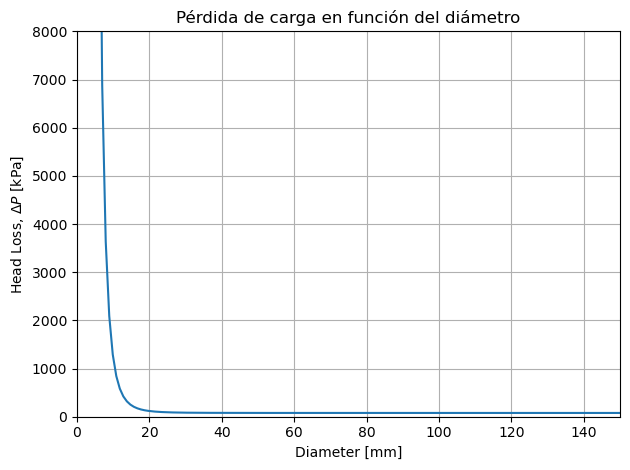

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(D_range * 1000, Delta_P_range)
plt.xlabel("Diameter [mm]")
plt.ylabel(r"Head Loss, $\Delta P$ [kPa]")
plt.title("Pérdida de carga en función del diámetro")
plt.xlim([0, 150])
plt.ylim([0, 8000])
plt.grid(True)
plt.tight_layout()